# 1. Setup and Get Data

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

You should consider upgrading via the 'D:\Projects\FaceDetection\facedetection\Scripts\python.exe -m pip install --upgrade pip' command.



  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)


In [1]:
import os
import time
import uuid
import cv2

In [3]:
IMAGE_PATH = os.path.join('data', 'images')
image_count = 20

In [12]:
# loading the camera
cap = cv2.VideoCapture(0)
for image_num in range(image_count):
    print('Collecting image ::: {}'.format(image_num))
    # capture an image from the camera
    ret, frame = cap.read()
    imageName = os.path.join(IMAGE_PATH, f'{str(uuid.uuid1())}.jpg')
    # write the image in the file path
    cv2.imwrite(imageName, frame)
    #cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

# closing the camera
cap.release()
# close any windows if present and displaying the image frames
cv2.destroyAllWindows()

[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] font_manager:_rebuild:1337 - generated new fontManager
[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\tonyr\.labelmerc


In [13]:
# annotate bounding box values for the images
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\tonyr\.labelmerc


# 2. Review dataset and build image loading function

In [2]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# limit gpu memory growth
# avoid out of memory error by setting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, False)

In [19]:
# read all the image file names
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle = False)

In [3]:
def load_image(imageName):
    byte_img = tf.io.read_file(imageName)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [22]:
images = images.map(load_image)

In [23]:
images.as_numpy_iterator().next()

array([[[223, 233, 235],
        [224, 234, 236],
        [223, 234, 236],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       [[222, 232, 234],
        [223, 233, 235],
        [222, 233, 235],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       [[222, 232, 234],
        [223, 233, 235],
        [222, 233, 235],
        ...,
        [235, 235, 235],
        [235, 235, 235],
        [235, 235, 235]],

       ...,

       [[198, 207, 216],
        [198, 208, 217],
        [200, 208, 219],
        ...,
        [176, 179, 172],
        [178, 181, 172],
        [179, 182, 173]],

       [[197, 207, 217],
        [195, 208, 217],
        [199, 209, 219],
        ...,
        [177, 180, 173],
        [176, 181, 174],
        [177, 182, 175]],

       [[197, 210, 219],
        [198, 211, 220],
        [198, 210, 222],
        ...,
        [176, 179, 172],
        [175, 180, 173],
        [175, 180, 173]]

In [24]:
img_iterator = images.batch(4).as_numpy_iterator()

In [27]:
img_batch = img_iterator.next()

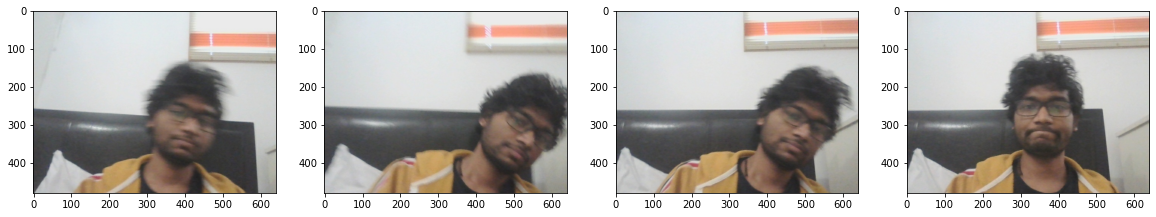

In [28]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))
for index, image in enumerate(img_batch):
    ax[index].imshow(image)
plt.show()

# 3. Extracting labels and splitting dataset

In [29]:
# move the matching labels to their corresponding paths
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        labelName = file.split('.')[0] + '.json'
        existing_dir = os.path.join('data', 'labels', labelName)
        if os.path.exists(existing_dir):
            new_dir = os.path.join('data', folder, 'labels', labelName)
            os.replace(existing_dir, new_dir)

# 4. Data augmentation with albumentations

In [5]:
import albumentations as alb

In [33]:
augmentor = alb.Compose(
    [
        alb.RandomCrop(width = 450, height = 450),
        alb.RandomBrightnessContrast(p = 0.2),
        alb.HorizontalFlip(p = 0.5),
        alb.VerticalFlip(p = 0.5),
        alb.RandomGamma(p = 0.2),
        alb.RGBShift(p = 0.2)
    ],
    bbox_params = alb.BboxParams(
        format = 'albumentations',
        label_fields = ['class_labels']
    )
)

In [78]:
img = cv2.imread(os.path.join('data', 'train', 'images', 'f51e85da-0489-11ed-81d8-900f0ca40854.jpg'))

In [79]:
with open(os.path.join('data', 'train', 'labels', 'f51e85da-0489-11ed-81d8-900f0ca40854.json'), 'r') as f:
    label = json.load(f)

In [80]:
coords = list(np.array(label['shapes'][0]['points']).ravel())

In [81]:
coords = np.divide(coords, [640, 480, 640, 480])

In [82]:
augmented = augmentor(image = img, bboxes = [coords], class_labels = ['face'])

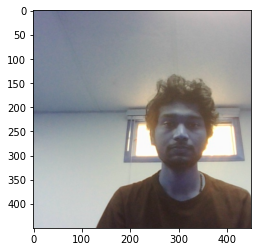

In [83]:
plt.imshow(augmented['image'])

In [93]:
tuple(list(np.array(label['shapes'][0]['points']).ravel())[:2])

(237.5641025641026, 137.94871794871796)

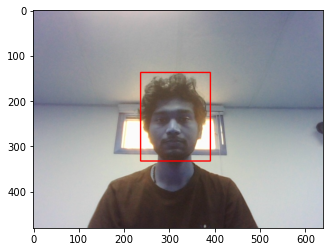

In [97]:
orig_img = cv2.rectangle(img,
                        tuple(list(np.array(label['shapes'][0]['points'], dtype = 'int').ravel())[:2]),
                        tuple(list(np.array(label['shapes'][0]['points'], dtype = 'int').ravel())[2:]),
                        (255, 0, 0), 2)
plt.imshow(img)

In [85]:
augmented['image'].shape

(450, 450, 3)

In [86]:
augmented['bboxes']

[(0.49686609686609684,
  0.2954415954415955,
  0.8387464387464387,
  0.7284900284900285)]

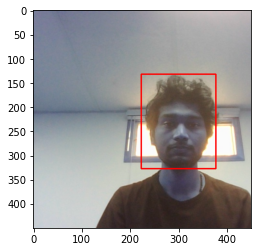

In [87]:
augmented_img = cv2.rectangle(augmented['image'],
                             tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype('int')),
                             tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype('int')),
                             (255, 0, 0), 2)
plt.imshow(augmented_img)

# 5. Run augmentation for the complete dataset

In [101]:
for folder in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join('data', folder, 'images')):
        img = cv2.imread(os.path.join('data', folder, 'images', image))
        labelFilePath = os.path.join('data', folder, 'labels', image.split('.')[0] + '.json')
        coords = [0, 0, 0.01, 0.01]
        if os.path.exists(labelFilePath):
            with open(labelFilePath, 'r') as f:
                label = json.load(f)
            coords = list(np.array(label['shapes'][0]['points']).ravel())
            coords = np.divide(coords, [640, 480, 640, 480])
        try:    
            for x in range(60):
                augmented = augmentor(image = img,
                                     bboxes = [coords],
                                     class_labels = ['face'])
                annotated = {}
                annotated['image'] = image.split('.')[0] + '.' + str(x) + '.jpg'
                cv2.imwrite(os.path.join('aug_data', folder, 'images', annotated['image']), augmented['image'])

                if os.path.exists(labelFilePath):
                    if len(augmented['bboxes']) == 0:
                        annotated['bboxes'] = [0, 0, 0, 0]
                        annotated['class'] = 0
                    else:
                        annotated['bboxes'] = augmented['bboxes'][0]
                        annotated['class'] = 1
                else:
                    annotated['bboxes'] = [0, 0, 0, 0]
                    annotated['class'] = 0

                with open(os.path.join('aug_data', folder, 'labels', image.split('.')[0] + '.' + str(x) + '.json'), 'w') as f:
                    json.dump(annotated, f)
                    
        except Exception as e:
            print (e)

In [4]:
# loading the datasets
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x , (120, 120)))
train_images = train_images.map(lambda x: x / 255)

In [5]:
val_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

# 6. Load the labels

In [7]:
def load_labels(labelPath):
    with open(labelPath.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    
    return [label['class']], label['bboxes']

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Merge the features and labels

In [11]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(1000)
train = train.batch(8)
train = train.prefetch(4)

In [12]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(10)
val = val.batch(8)
val = val.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(444)
test = test.batch(8)
test = test.prefetch(4)

In [14]:
sample_iterator = train.as_numpy_iterator()

In [15]:
samples = sample_iterator.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


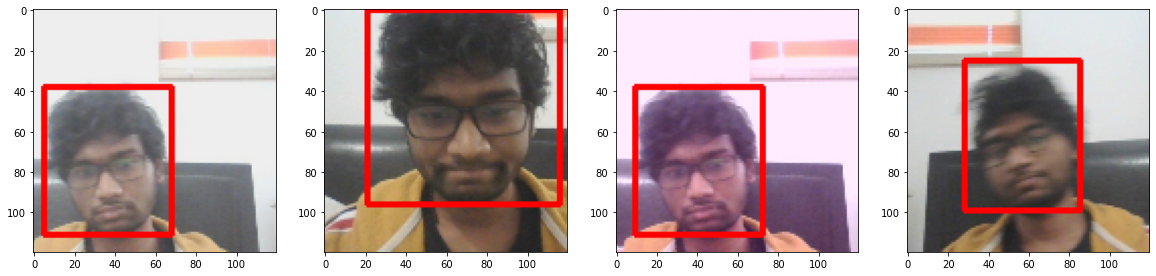

In [16]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))

for idx in range(4):
    img = samples[0][idx]
    coords = samples[1][1][idx]
    
    aug_img = cv2.rectangle(img,
                           tuple(np.multiply(coords[:2], (120, 120)).astype('int')),
                           tuple(np.multiply(coords[2:], (120, 120)).astype('int')),
                           (255, 0, 0), 2)
    ax[idx].imshow(aug_img)

# 8. Build Deep Learning model

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalMaxPooling2D, Dense
from tensorflow.keras.applications import VGG16

In [114]:
vgg = VGG16(include_top = False)

In [115]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [116]:
def face_detection_model():
    input_img = Input(shape = (120, 120, 3))
    
    vgg = VGG16(include_top = False)(input_img)
    
    # classification
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = 'relu')(f1)
    class2 = Dense(1, activation = 'sigmoid')(class1)
    
    # boundary box prediction
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = 'relu')(f2)
    regress2 = Dense(4, activation = 'sigmoid')(regress1)
    
    faceDetector = Model(inputs = input_img, outputs = [class2, regress2])
    
    return faceDetector

In [117]:
def localization_loss(y_true, y_pred):
    mse1 = tf.reduce_sum(tf.square(y_true[:, :2] - y_pred[:, :2]))
    
    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]
    
    h_pred = y_pred[:, 3] - y_pred[:, 1]
    w_pred = y_pred[:, 2] - y_pred[:, 0]
    
    mse2 = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return mse1 + mse2

In [118]:
faceDetector = face_detection_model()

In [119]:
faceDetector.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_8[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [120]:
X, y = train.as_numpy_iterator().next()

In [121]:
y_hat = faceDetector.predict(X)

1/1 [==============================] - 0s 132ms/step


In [122]:
y_hat

[array([[0.36352333],
        [0.442414  ],
        [0.3633851 ],
        [0.44320354],
        [0.39198565],
        [0.43537807],
        [0.4941544 ],
        [0.41971076]], dtype=float32),
 array([[0.70677537, 0.4774145 , 0.4075808 , 0.6216184 ],
        [0.73342305, 0.41580406, 0.49609128, 0.5520116 ],
        [0.6529782 , 0.46683612, 0.41817963, 0.60287863],
        [0.6351577 , 0.4261393 , 0.45869872, 0.46014908],
        [0.72396696, 0.37835708, 0.4076824 , 0.51465774],
        [0.6401021 , 0.44068685, 0.44359627, 0.5292923 ],
        [0.6650055 , 0.52428705, 0.4601159 , 0.5463527 ],
        [0.6046181 , 0.4408886 , 0.4457623 , 0.5358037 ]], dtype=float32)]

In [123]:
lr_decay = (1./0.75 -1)/len(train)

In [124]:
faceDetector.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay = lr_decay),
                     loss = [tf.keras.losses.binary_crossentropy, localization_loss])

In [125]:
hist = faceDetector.fit(train, epochs = 20, validation_data = val)

Epoch 1/20
698/698 [==============================] - 86s 117ms/step - loss: 0.2737 - dense_9_loss: 0.0547 - dense_11_loss: 0.2190 - val_loss: 2.1831 - val_dense_9_loss: 0.9451 - val_dense_11_loss: 1.2379
Epoch 2/20
698/698 [==============================] - 83s 117ms/step - loss: 0.0781 - dense_9_loss: 0.0178 - dense_11_loss: 0.0603 - val_loss: 2.0761 - val_dense_9_loss: 0.9134 - val_dense_11_loss: 1.1627
Epoch 3/20
698/698 [==============================] - 84s 118ms/step - loss: 0.0592 - dense_9_loss: 0.0156 - dense_11_loss: 0.0436 - val_loss: 2.1734 - val_dense_9_loss: 0.8428 - val_dense_11_loss: 1.3306
Epoch 4/20
698/698 [==============================] - 85s 119ms/step - loss: 0.0442 - dense_9_loss: 0.0127 - dense_11_loss: 0.0315 - val_loss: 2.3168 - val_dense_9_loss: 0.9907 - val_dense_11_loss: 1.3262
Epoch 5/20
698/698 [==============================] - 86s 121ms/step - loss: 0.0296 - dense_9_loss: 0.0068 - dense_11_loss: 0.0228 - val_loss: 2.4573 - val_dense_9_loss: 1.0627 - v

In [126]:
faceDetector.save('facedetector.h5')

# 9. Prediction

In [127]:
test_iterator = test.as_numpy_iterator()

In [229]:
X, y = test_iterator.next()

In [231]:
y_hat = faceDetector.predict(np.expand_dims(X[0], 0))

1/1 [==============================] - 1s 694ms/step


In [242]:
y_hat[0][0].as

array([0.9999999], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


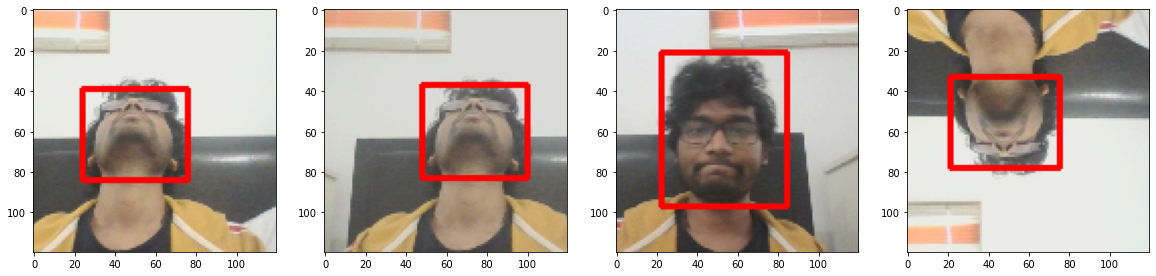

In [227]:
fig, ax = plt.subplots(ncols = 4, figsize = (20, 20))

for idx in range(4):
    img = X[idx]
    coords = y_hat[1][idx]
    
    if y_hat[0][idx] > 0.5:
        cv2.rectangle(img,
                              tuple(np.multiply(coords[:2], (120, 120)).astype('int')),
                              tuple(np.multiply(coords[2:], (120, 120)).astype('int')),
                              (255, 0, 0), 2)
        
    ax[idx].imshow(img)

# 10. Real-time detection

In [250]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = tf.image.resize(np.expand_dims(rgb / 255, 0), (120, 120))
    
    y_pred = faceDetector.predict(img)
    coords = y_pred[1][0]
    
    if y_pred[0][0] > 0.8:
        # bounding box
        cv2.rectangle(frame,
                     tuple(np.multiply(coords[:2], (450, 450)).astype('int')),
                     tuple(np.multiply(coords[2:], (450, 450)).astype('int')),
                     (255, 0, 0), 2)
        
    
    cv2.putText(frame,
               str(float(y_pred[0][0])),
               tuple(np.add(np.multiply(coords[:2], (450, 450)).astype('int'), (0, -5))),
               cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    
    cv2.imshow('Face Tracker', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 5ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 27ms/step
